# Monk3
Grid Search for Monk1 dataset model selection


In [43]:
from exclusiveAI.components.Validation.HoldOut import parallel_hold_out, hold_out
from exclusiveAI.components.Validation.KFoldCrossValidation import validate
from exclusiveAI.ConfiguratorGen import ConfiguratorGen
from exclusiveAI.datasets.monk import read_monk3
from exclusiveAI.utils import one_hot_encoding
from exclusiveAI.Composer import Composer
from exclusiveAI.components.CallBacks import EarlyStoppingCallback
from tqdm import tqdm
import pandas as pd
import numpy as np
from exclusiveAI.utils import plot_history
import os, json

#### Read Monk3 dataset 

In [44]:
training_data, training_labels, test_data, test_labels = read_monk3("../exclusiveAI/datasets/")

One-Hot Encoding Training Dataset

In [45]:
training_data = one_hot_encoding(training_data)

One-Hot Encoding Test Dataset

In [46]:
test_data = one_hot_encoding(test_data)

Getting the (most interesting) models from the big grid search 

In [47]:
def read_json_files(my_dir_path):
        data = pd.DataFrame()
        for file in os.listdir(my_dir_path):
            if file.endswith('.json'):
                with open(os.path.join(my_dir_path, file), 'r') as f:
                    my_data = [data['0'] for data in json.load(f).values()][1]
                    data = pd.concat([data,  pd.DataFrame(my_data)], ignore_index=True, axis=0)
        return data
batch_size = 64
epochs = 500

final_file = 'monk3_models_configs_hist3.json'

if not os.path.exists(final_file):
    dir_path = "Monk3/"
    
    all_json_data = read_json_files(dir_path)
    regularizations = all_json_data['regularization'].unique().tolist()
    learning_rates = all_json_data['learning_rate'].unique().tolist()
    learning_rates = set([value if 0.09 < value< 0.25 else 0.1 for value in learning_rates])
    # momentums = all_json_data['momentum'].unique().tolist()
    momentums = [0.1, 0.2, 0]
    num_of_layers = [2]#all_json_data['num_layers'].unique().tolist()
    num_of_units = set([unit1 for unit in all_json_data['num_of_units'] for unit1 in unit])
    initializers = ["uniform", "gaussian"]
    activations = ["sigmoid"]
    
    myConfigurator = ConfiguratorGen(random=False, learning_rates=learning_rates, regularizations=regularizations,
                                     loss_function=['mse'], optimizer=['sgd'],
                                     activation_functions=activations,
                                     number_of_units=num_of_units, number_of_layers=num_of_layers,
                                     momentums=momentums, initializers=initializers,
                                     input_shapes=training_data.shape,
                                     verbose=False, nesterov=True,
                                     callbacks=["earlystopping"], output_activation='linear', show_line=False,
                                     ).get_configs()
    len(myConfigurator)
    
    configs=[]
    if __name__ == '__main__':
        configs.append(
            parallel_hold_out(myConfigurator, training=training_data, training_target=training_labels, epochs=epochs, regression=True,
                              batch_size=batch_size, num_models=100, workers=4, number_of_initializations=3, return_models_history=True,
                              ))
    
        configs = pd.DataFrame(configs)
        # Save as json
        configs.to_json(final_file)
else: 
    with open(final_file, 'r') as f:
        configs = [data['0'] for data in json.load(f).values()]

In [48]:
# my_configs = []
# for config in configs[1]:
#     config['callbacks'] = ['earlystopping_1e-4_20_False']
# ea = EarlyStoppingCallback(restore_weights=True)
config = {'regularization': 1e-07, 'learning_rate': 0.22, 'loss_function': 'mse', 'activation_functions': ['tanh'], 'output_activation': 'sigmoid', 'num_of_units': [3], 'num_layers': 1, 'momentum': 0.1, 'optimizer': 'sgd', 'initializers': 'uniform', 'nesterov': True, 'input_shape': [122, 17], 'callbacks': ['earlystopping_1e-7_50_True_True'], 'verbose': False, 'outputs': 1, 'model_name': 'Model2427'}
configs[1] = [config for _ in range(10)]
# if __name__ == '__main__':
#     # for config in configs[1]:
#     #     config['callbacks'] = [ea]
#     my_configs.append(
#         validate(configs[1], x=training_data, y_true=training_labels, epochs=epochs, return_models_history=True,
#                           batch_size=batch_size, max_configs=100, number_of_initializations=1, n_splits=4, parallel=False
#                           ))
#     
#     # my_configs.append(
#     #     hold_out(configs[1], training=training_data, training_target=training_labels, epochs=epochs, return_models_history=True,
#     #                       batch_size=batch_size, num_models=100, number_of_initializations=2,
#     #                       ))
# 
# configs=my_configs[0]

In [49]:
models = []
old_histories = configs[0]
my_configs=configs[1]
with tqdm(total=len(my_configs)) as pbar:
    for old_hist, config in zip(old_histories, my_configs):
        model = Composer(config=config).compose()
        model.train(inputs=training_data, input_label=training_labels, val=test_data, val_labels=test_labels, epochs=epochs, batch_size=batch_size, name=config['model_name'], disable_line=True)
        test_val = model.evaluate(input=test_data, input_label=test_labels)
        models.append((model.get_last()['mse'], np.std(np.array(model.history['mse'])), model.get_last()['binary_accuracy'], test_val[0], test_val[1], model.curr_epoch, max(old_hist['binary_accuracy']),  max(old_hist['val_binary_accuracy']), model.history['mse'],  model.history['mse'], model.history['val_mse'], model.history['binary_accuracy'], model.history['val_binary_accuracy'], Composer(config=config).compose(), config, config['num_layers'], config['num_of_units'], config['model_name']))
        pbar.update(1)

# Convert the list of tuples to a DataFrame with one column for each element in the tuple
df = pd.DataFrame(models, columns=['Score', 'History_Std', 'Accuracy', 'Test_Score', 'Test_Accuracy', 'Trained_Epochs', 'Old_Accuracy', 'Old_Accuracy_val', 'Old_History', 'Old_History_val', 'History', 'Accuracy_History', 'Val_Accuracy_History', 'Model', 'Config', 'Num_Layers', 'Num_of_Units', 'Name'])

100%|██████████| 10/10 [00:01<00:00,  9.31it/s]


In [50]:
# Sort the DataFrame by the first element in the tuple (column 'Value')

df_sorted = df.sort_values(by=['Num_Layers', 'Score', 'Test_Score', 'History_Std'])
# df_sorted = df_sorted[df_sorted['Accuracy'] >= 0.95] 
# df_sorted = df_sorted[df_sorted['Test_Accuracy'] >= 0.96]
# df_sorted = df_sorted[df_sorted['Old_Accuracy_val'] >= 0.97]
# df_sorted = df_sorted[df_sorted['History_Std'] <= 0.1] 
# df_sorted = df_sorted[df_sorted['Num_Layers'] <= 1]
# df_sorted['Num_of_Units'] = [value[0] for value in df_sorted['Num_of_Units']]
# df_sorted = df_sorted[df_sorted['Num_of_Units'] == 4]
histories = {row[0]: row[1] for row in df_sorted[['Name', 'History']].values}
old_histories = {row[0]: row[1] for row in df_sorted[['Name', 'Old_History']].values}
old_histories_val = {row[0]: row[1] for row in df_sorted[['Name', 'Old_History_val']].values}
df_sorted

,Score,History_Std,Accuracy,Test_Score,Test_Accuracy,Trained_Epochs,Old_Accuracy,Old_Accuracy_val,Old_History,Old_History_val,History,Accuracy_History,Val_Accuracy_History,Model,Config,Num_Layers,Num_of_Units,Name
1,0.044198,0.065735,0.950820,0.040311,0.958333,343,0.958763,0.88,"[0.2671127, 0.2647014, 0.26260626, 0.2607108, ...","[0.2671127, 0.2647014, 0.26260626, 0.2607108, ...","[0.2664829, 0.26421273, 0.26216367, 0.26032135...","[0.4098360655737705, 0.4262295081967213, 0.450...","[0.4097222222222222, 0.42592592592592593, 0.43...",<exclusiveAI.components.NeuralNetwork.NeuralNe...,"{'regularization': 1e-07, 'learning_rate': 0.2...",1,[3],Model2427
0,0.046229,0.056766,0.942623,0.039689,0.960648,320,0.969072,0.88,"[0.241681, 0.24085152, 0.24003014, 0.23918715,...","[0.241681, 0.24085152, 0.24003014, 0.23918715,...","[0.2441861, 0.24337462, 0.24252866, 0.24167423...","[0.5491803278688525, 0.5491803278688525, 0.573...","[0.5717592592592593, 0.5763888888888888, 0.583...",<exclusiveAI.components.NeuralNetwork.NeuralNe...,"{'regularization': 1e-07, 'learning_rate': 0.2...",1,[3],Model2427
4,0.046510,0.055816,0.942623,0.040830,0.962963,319,0.958763,0.92,"[0.24533868, 0.243892, 0.24263085, 0.24139418,...","[0.24533868, 0.243892, 0.24263085, 0.24139418,...","[0.24797681, 0.24638674, 0.24502441, 0.2436947...","[0.5573770491803278, 0.5491803278688525, 0.557...","[0.5462962962962963, 0.5486111111111112, 0.557...",<exclusiveAI.components.NeuralNetwork.NeuralNe...,"{'regularization': 1e-07, 'learning_rate': 0.2...",1,[3],Model2427
2,0.047777,0.071960,0.942623,0.042472,0.960648,302,0.948454,0.88,"[0.2652923, 0.2621293, 0.25966817, 0.2576066, ...","[0.2652923, 0.2621293, 0.25966817, 0.2576066, ...","[0.27688, 0.27276284, 0.26949126, 0.2667106, 0...","[0.5081967213114754, 0.5081967213114754, 0.516...","[0.4652777777777778, 0.4675925925925926, 0.467...",<exclusiveAI.components.NeuralNetwork.NeuralNe...,"{'regularization': 1e-07, 'learning_rate': 0.2...",1,[3],Model2427
9,0.048034,0.041294,0.942623,0.039433,0.962963,256,0.958763,0.88,"[0.21703146, 0.21429384, 0.21160135, 0.2088911...","[0.21703146, 0.21429384, 0.21160135, 0.2088911...","[0.21679915, 0.21376579, 0.21075246, 0.2077578...","[0.7540983606557377, 0.7540983606557377, 0.754...","[0.6967592592592593, 0.7083333333333334, 0.722...",<exclusiveAI.components.NeuralNetwork.NeuralNe...,"{'regularization': 1e-07, 'learning_rate': 0.2...",1,[3],Model2427
5,0.049585,0.065459,0.942623,0.044759,0.960648,248,0.958763,0.92,"[0.26846203, 0.26411495, 0.26056835, 0.2575159...","[0.26846203, 0.26411495, 0.26056835, 0.2575159...","[0.2683392, 0.2647808, 0.26188216, 0.25937632,...","[0.47540983606557374, 0.48360655737704916, 0.4...","[0.4976851851851852, 0.5023148148148148, 0.497...",<exclusiveAI.components.NeuralNetwork.NeuralNe...,"{'regularization': 1e-07, 'learning_rate': 0.2...",1,[3],Model2427
3,0.050554,0.058432,0.942623,0.044986,0.960648,222,0.958763,0.88,"[0.24607328, 0.24409993, 0.24230134, 0.2405595...","[0.24607328, 0.24409993, 0.24230134, 0.2405595...","[0.25009647, 0.24794003, 0.24598321, 0.2441102...","[0.5245901639344263, 0.5573770491803278, 0.581...","[0.5115740740740741, 0.5300925925925926, 0.553...",<exclusiveAI.components.NeuralNetwork.NeuralNe...,"{'regularization': 1e-07, 'learning_rate': 0.2...",1,[3],Model2427
8,0.053040,0.078097,0.942623,0.042956,0.967593,232,0.958763,0.88,"[0.26901165, 0.26577598, 0.2633604, 0.26126775...","[0.26901165, 0.26577598, 0.2633604, 0.26126775...","[0.26243126, 0.26006046, 0.25832158, 0.2568550...","[0.4918032786885246, 0.4918032786885246, 0.491...","[0.5277777777777778, 0.5277777777777778, 0.527...",<exclusiveAI.components.NeuralNetwork.NeuralNe...,"{'regularization': 1e-07, 'learning_rate': 0.2...",1,[3],Model2427
6,0.053096,0.052134,0.942623,0.045206,0.965278,194,0.969072,0.88,"[0.23888575, 0.23546265, 0.23254924, 0.2297082...","[0.23888575, 0.23546265, 0.23254924, 0.2297082...","[0.24653023, 0.24257734, 0.23925431, 0.2360136...","[0.5491803278688525,

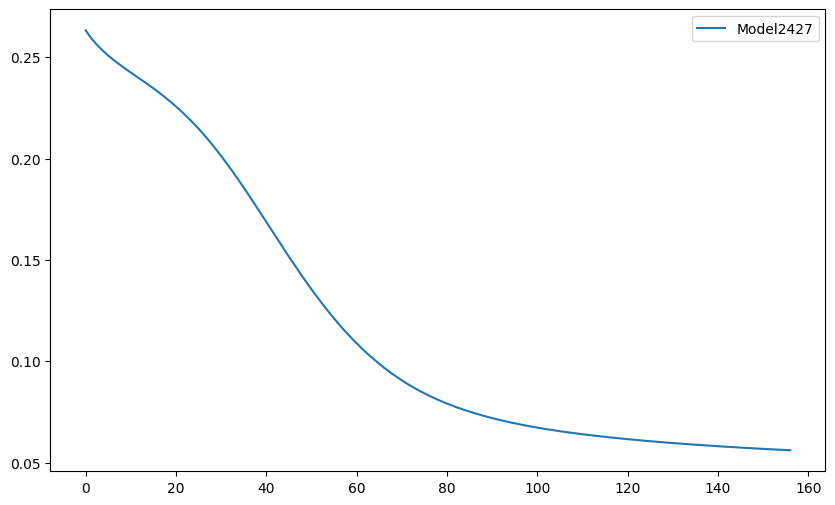

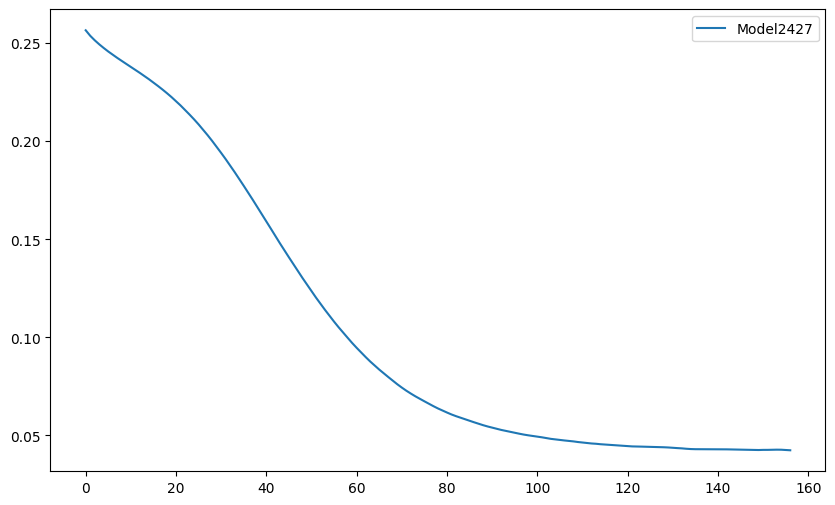

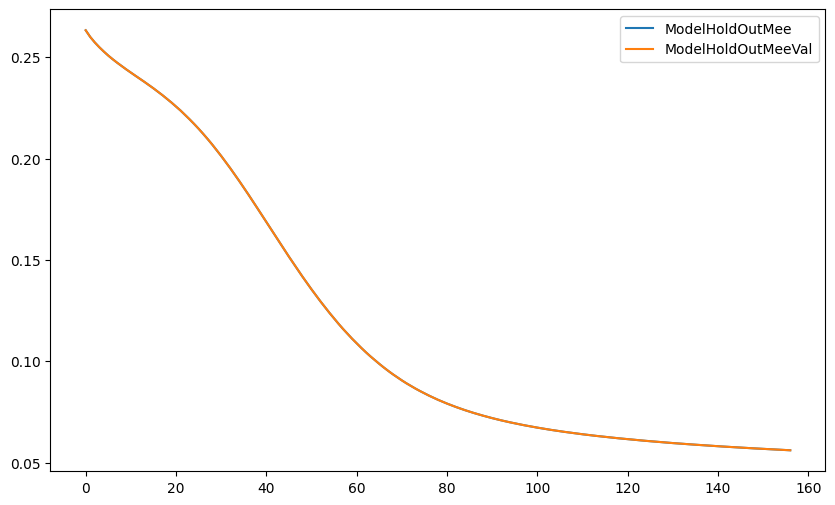

In [51]:
plot_history(old_histories_val)
plot_history({list(histories)[0]: list(histories.values())[0]})
plot_history({'ModelHoldOutMee': list(old_histories.values())[0], 'ModelHoldOutMeeVal': list(old_histories_val.values())[0]})
# plot_history({list(histories)[1]: list(histories.values())[1]})


In [52]:
def find_least_difference_row(my_df):
    min_diff = float('inf')
    selected_row = None

    for index, row in my_df.iterrows():
        array1 = np.array(row['History'])
        differences1 =  (np.diff(array1) - np.mean(array1)) /np.mean(array1)
        min_consecutive_difference = np.min(differences1)

        if min_consecutive_difference < min_diff:
            min_diff = min_consecutive_difference
            selected_row = row

    return selected_row

result_row = find_least_difference_row(df_sorted)
# Pivot the DataFrame using 'Unnamed: 0' as both index and columns
print(result_row)
result_row.to_csv('Monk3_train.csv')

Score                                                            0.048034
History_Std                                                      0.041294
Accuracy                                                         0.942623
Test_Score                                                       0.039433
Test_Accuracy                                                    0.962963
Trained_Epochs                                                        256
Old_Accuracy                                                     0.958763
Old_Accuracy_val                                                     0.88
Old_History             [0.21703146, 0.21429384, 0.21160135, 0.2088911...
Old_History_val         [0.21703146, 0.21429384, 0.21160135, 0.2088911...
History                 [0.21679915, 0.21376579, 0.21075246, 0.2077578...
Accuracy_History        [0.7540983606557377, 0.7540983606557377, 0.754...
Val_Accuracy_History    [0.6967592592592593, 0.7083333333333334, 0.722...
Model                   <exclusiveAI.c

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


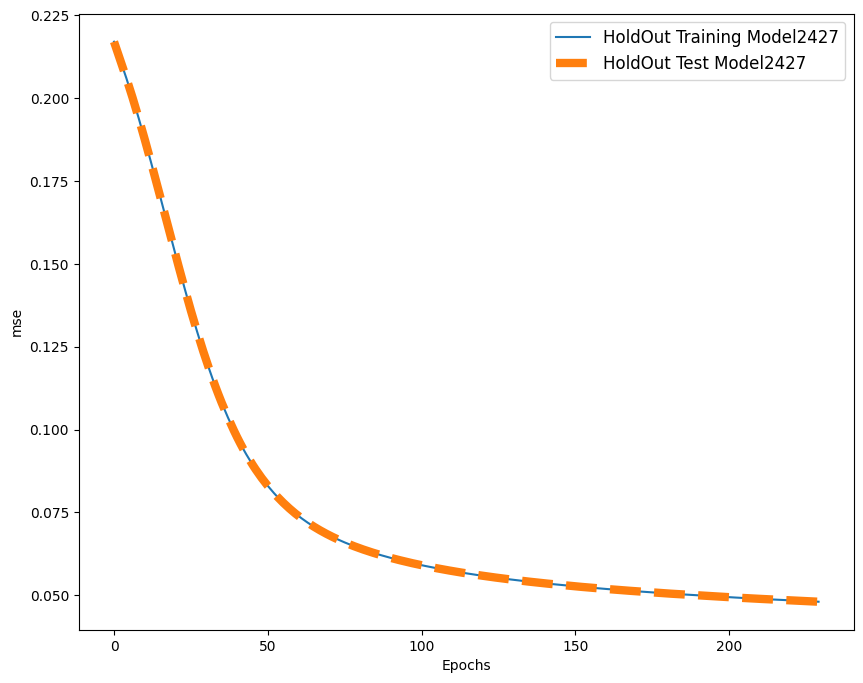

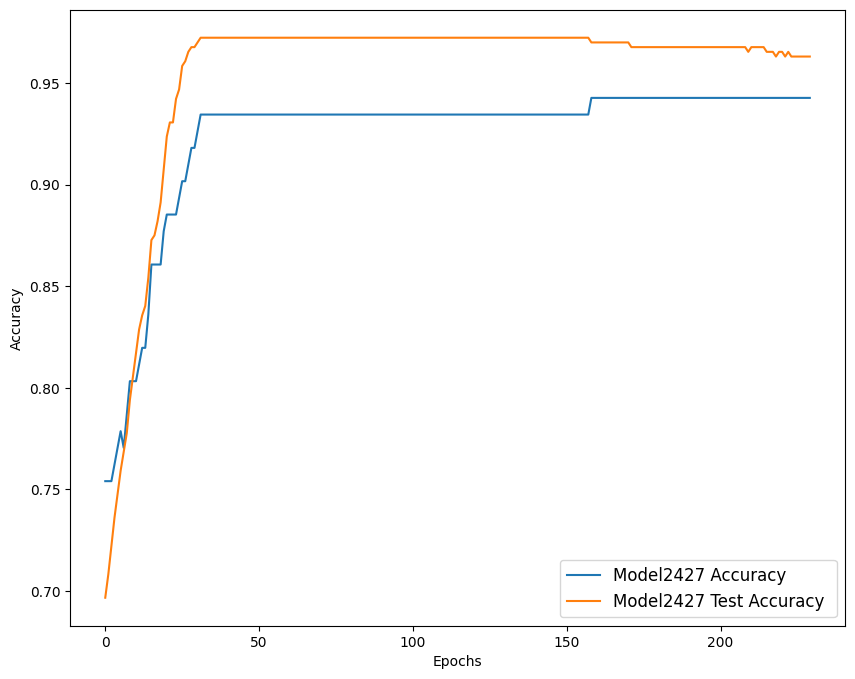

In [67]:
import matplotlib.pyplot as plt
def plot_history2(name, lines: dict, fig_size=(10, 6), label='mse', line=False):
    plt.figure(figsize=fig_size)
    for i, elem in enumerate(lines):
        if line and len(lines) == 2 and i==1:
            plt.plot(lines[elem], label=elem, linestyle='dashed', linewidth=6)
        else:
            plt.plot(lines[elem], label=elem)
    plt.legend(fontsize='12')
    plt.xlabel('Epochs')
    plt.ylabel(label)
    plt.savefig(name+'.eps', format='eps')
    plt.savefig(name+'.png', format='png')

# plot_history2(name='Monk1_train', lines={result_row["Name"]: result_row['History']}, fig_size=(10,8))
plot_history2(name='Monk3_KFold', lines={'HoldOut Training '+result_row["Name"]: -np.sort(-np.array(result_row['Old_History'])), 'HoldOut Test '+result_row["Name"]: -np.sort(-np.array(result_row['Old_History_val']))}, fig_size=(10,8), line=True)
plot_history2(name='Monk3_Accuracy', lines={result_row["Name"]+" Accuracy ": result_row['Accuracy_History'], result_row["Name"]+" Test Accuracy ": result_row['Val_Accuracy_History']}, fig_size=(10,8), label='Accuracy')

{'regularization': 1e-07, 'learning_rate': 0.22, 'loss_function': 'mse', 'activation_functions': ['tanh'], 'output_activation': 'sigmoid', 'num_of_units': [3], 'num_layers': 1, 'momentum': 0.1, 'optimizer': 'sgd', 'initializers': 'uniform', 'nesterov': True, 'input_shape': [122, 17], 'callbacks': ['earlystopping_1e-4_50_False_True'], 'verbose': False, 'outputs': 1, 'model_name': 'Model2427'}